In [1]:
import os
import sys
import json
import torch
import shutil

sys.path.append('/home/sid/Projects/OmniScience/code/reprojection')
sys.path.append('/home/sid/Projects/OmniScience/other/humor')

# os.environ["CUDA_VISIBLE_DEVICES"]="1"
from humor.fitting.fitting_utils import load_res, prep_res, run_smpl
from humor.body_model.body_model import BodyModel
from humor.body_model.utils import SMPL_JOINTS
from humor.fitting.eval_utils import SMPL_SIZES
from humor.utils.torch import copy2cpu as c2c

# from reprojection
from humor_inference.reproject_humor_sequence import make_44, transform_SMPL_sequence, get_camera_params,sanitize_preds
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import List
import trimesh
from IPython.display import display, clear_output
from PIL import Image, ImageDraw, ImageOps
from tqdm.autonotebook import tqdm
import pandas as pd

/home/sid/miniforge-pypy3/envs/humor/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reprojecting

In [2]:
def change_to_radians(degree):
    return degree * np.pi / 180

def transform_camera(transform):
    # Translation matrix to move the center of the image to the origin
    image_width = 1200
    image_height = 900

    rx = change_to_radians(0)
    ry = change_to_radians(0)
    rz = change_to_radians(-120)

    rotation_angles = np.array([rx, ry, rz])
    translation_vector = np.array([0,0,0])
    rx = rotation_angles[0]
    
    rotation_x = np.array([[1, 0, 0, 0],
                           [0, np.cos(rx), -np.sin(rx), 0],
                           [0, np.sin(rx), np.cos(rx), 0],
                           [0, 0, 0, 1]])
    
    ry = rotation_angles[1]
    rotation_y = np.array([[np.cos(ry), 0, np.sin(ry), 0],
                           [0, 1, 0, 0],
                           [-np.sin(ry), 0, np.cos(ry), 0],
                           [0, 0, 0, 1]])
    rz = rotation_angles[2]
    rotation_z = np.array([[np.cos(rz), -np.sin(rz), 0, 0],
                           [np.sin(rz), np.cos(rz), 0, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
    
    tx, ty, tz = translation_vector
    translation = np.array([[1, 0, 0, tx],
                            [0, 1, 0, ty],
                            [0, 0, 1, tz],
                            [0, 0, 0, 1]])

    R =  rotation_x @ rotation_y @ rotation_z @ translation

    transform = np.linalg.inv(R) @ transform
    return transform

In [12]:
sync_file = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/synced_filenames_full.txt"
capture_dir = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/capture2/rgb"

def get_synced_meshes(transformed_meshes):

    df = pd.read_csv(sync_file, sep=";", header=0)
    capture_files = sorted(os.listdir(capture_dir))

    mesh_indices = []
    for ix, val in df.iterrows():
        # get index of val["capture0"] in capture_files
        mesh_index = capture_files.index(val["capture2"])
        mesh_indices.append([mesh_index, val["omni"]])

    print("mesh indices: ", mesh_indices)

    # Select only the meshes from transformed_meshes which are in mesh_indices
    transformed_meshes_new = [transformed_meshes[i[0]] for i in mesh_indices]
    print(len(transformed_meshes_new))
    synced_cam1_files = [i[1] for i in mesh_indices]
    return synced_cam1_files, transformed_meshes_new

In [13]:
def render_on_images(
    images_dir: str,
    mesh_seq: List[trimesh.Trimesh],
    camera_calib: dict,
    output_dir: str,
):
    """
    Render the mesh sequence on the images in the directory.
    """
    # Load the camera intrinsics and distortion coefficients from the pickle file
    use_omni, camera_matrix, xi, dist_coeffs = get_camera_params(camera_calib)

    # Load all images in the directory
    images = []
    for filename in sorted(os.listdir(images_dir)):
        # If the file type is an image, load it
        if filename.endswith(".png") or filename.endswith(".jpg"):
            images.append(filename)

    synced_cam1_files, mesh_seq = get_synced_meshes(mesh_seq)
    images = [i for i in images if i in synced_cam1_files]
    images = [os.path.join(images_dir, i) for i in images]

    # assert len(mesh_seq) == len(images), "Number of images and meshes must be the same!"
    print(f"Number of images: {len(images)}")
    
    print(f"Number of meshes: {len(mesh_seq)}")
    if len(images) > len(mesh_seq):
        images = images[: len(mesh_seq)]
        print("Warning: more images than meshes, truncating images to match.")
    elif len(images) < len(mesh_seq):
        mesh_seq = mesh_seq[: len(images)]
        print("More meshes than images, truncating meshes to match.")
    # For each image in the folder, project the mesh on it using opencv's projectPoints.
    # Then, render the mesh on the image using PIL.
    for i, (mesh, img_path) in tqdm(
        enumerate(zip(mesh_seq, images)), total=len(images)
    ):
        img = Image.open(img_path)
        assert (img.size[1], img.size[0]) == camera_calib[
            "img_shape"
        ], "Image shape must match the camera calibration!"
        # Project the vertices on the image
        # We've already transformed the vertices to the camera frame, so we can just
        # project them on the image without any transformation.
        if use_omni:
            vertices_2d, _ = cv2.omnidir.projectPoints(
                np.expand_dims(mesh.vertices, axis=0),
                np.zeros(3),
                np.zeros(3),
                camera_matrix,
                xi,
                dist_coeffs,
            )
            vertices_2d = vertices_2d.swapaxes(0, 1)

        else:
            vertices_2d, _ = cv2.projectPoints(
                mesh.vertices, np.zeros(3), np.zeros(3), camera_matrix, dist_coeffs
            )
        
        # # Swap the x and y axes of the mesh so it renders at (0,2) instead of (2,0)
        # mesh.vertices = mesh.vertices[:, [1, 0, 2]] 
        # Draw the mesh on the image
        try:
            img = ImageOps.mirror(img)
        except:
            print("Image: ", img_path)
            continue
        # img = ImageOps.mirror(img)
        draw = ImageDraw.Draw(img)

        for face in mesh.faces:
            face_vertices = vertices_2d[face]

            draw.polygon(
                [tuple(p[0]) for p in face_vertices],
                fill=None,
                outline="red",
                width=1,
            )
        # Save the image
        # img.save(os.path.join(output_dir, f"{i:08d}.png"))

        clear_output(wait=True)
        # # Display a smaller version of the image
        img = img.resize((int(img.size[0] / 2.), int(img.size[1] / 2.)))
        display(img)
        
        
    print("[*] Done!")
    return vertices_2d, mesh

In [14]:
def _parse_camera_parameters(params, camera_type):
    camera_params = {}

    if camera_type == 'kinect':
        fx, fy = tuple(params["FocalLength"])
        cx, cy = tuple(params["PrincipalPoint"])
        camera_params["k_params"] = (fx, fy, cx, cy)

        camera_params['K'] = np.asarray(params['IntrinsicMatrix']).T

        Dk = np.asarray(params["RadialDistortion"])
        Dp = np.asarray(params["TangentialDistortion"])
        if len(Dk) == 3:
            D = np.asarray([Dk[0], Dk[1], Dp[0], Dp[1], Dk[2]])
        else:
            D = np.asarray([Dk[0], Dk[1], Dp[0], Dp[1]])
        camera_params['D'] = D

    elif camera_type == 'omni':
        c0, c2, c3, c4 = params['Intrinsics']['MappingCoefficients']
        camera_params['Coeffs'] = np.array([c0, 0., c2, c3, c4])
        cx, cy = params['Intrinsics']['DistortionCenter']
        camera_params['Centre'] = (cx, cy)
        m = np.asarray(params['Intrinsics']['StretchMatrix'])
        camera_params['c'] = m[0, 0]
        camera_params['d'] = m[0, 1]
        camera_params['e'] = m[1, 0]

    else:
        raise ValueError("Unsupported camera type")


    RR = np.asarray(params["RotationMatrices"])
    camera_params["RR"] = [RR[:, :, i].T for i in range(RR.shape[2])]

    tt = np.asarray(params["TranslationVectors"])
    camera_params["tt"] = [tt[i] for i in range(tt.shape[0])]

    return camera_params


In [15]:
###########
# Matlab matrices
jsonpath = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/k2Params.json"
with open(jsonpath, "r") as f:
    kParams = json.load(f)

jsonpath = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/omni2Params.json"
with open(jsonpath, "r") as f:
    omniParams = json.load(f)

kinect_params = _parse_camera_parameters(kParams, 'kinect')
omni_params = _parse_camera_parameters(omniParams, 'omni')

R_kinect = kinect_params["RR"][0]
t_kinect = kinect_params["tt"][0].reshape(3, 1)

R_omni = omni_params["RR"][0]
t_omni = omni_params["tt"][0].reshape(3, 1)

meo = np.zeros((4, 4))
meo[0:3, 0:3] = R_omni
meo[:3, 3] = t_omni.ravel() / 1000.
meo[3, :] = np.asarray([0, 0, 0, 1])

mei = np.zeros((4, 4))
mei[0:3, 0:3] = R_kinect
mei[:3, 3] = t_kinect.ravel() / 1000.
mei[3, :] = np.asarray([0, 0, 0, 1])

composite_transform = np.matmul(meo, np.linalg.pinv(mei))

In [16]:
num = 2  # To set the capture number for extrinsics

cam0_to_world_pth = f"/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/calib/extrinsics/k{num}-extrinsics/capture{num}/k{num}_rgb_cam_to_world.pkl"
world_to_cam1_pth = f"/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/calib/extrinsics/k{num}-extrinsics/k{num}_omni_flipped_world_to_cam.pkl"

# cam1_calib_pth = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/calib/intrinsics/omni/omni_calib.pkl"
cam1_calib_pth = "/home/sid/Projects/OmniScience/code/reprojection/calibration/intrinsics/omni_intrinsics_flipped_2024.pkl"
cam1_images_path = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/omni"

results_folder = f"/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/capture{num}/results_out/final_results"
output_path = f"/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/capture{num}/results_out/reprojected"

res_file = os.path.join(results_folder, "stage3_results.npz")
if not os.path.isfile(res_file):
    raise Exception(f"Could not find {res_file}!")

device = torch.device("cpu")
pred_res = np.load(res_file)
T = pred_res["trans"].shape[0]

sanitize_preds(pred_res, T)
pred_res = prep_res(pred_res, device, T)
num_pred_betas = pred_res["betas"].size(1)

# create body models for each
meta_path = os.path.join(results_folder, "meta.txt")
if not os.path.exists(meta_path):
    raise Exception(f"Could not find {meta_path}!")
    
optim_bm_path = None
with open(meta_path, "r") as f:
    optim_bm_str = f.readline().strip()
    optim_bm_path = optim_bm_str.split(" ")[1]

# humor model
pred_bm = BodyModel(
    bm_path=optim_bm_path, num_betas=num_pred_betas, batch_size=T
).to(device)

# run through SMPL
pred_body = run_smpl(pred_res, pred_bm)
print("[*] Loaded the sequence of SMPL models!")

with open(cam0_to_world_pth, "rb") as f:
    cam0_to_world = make_44(pickle.load(f))

with open(world_to_cam1_pth, "rb") as f:
    world_to_cam1 = make_44(pickle.load(f))

transform = world_to_cam1 @ cam0_to_world
transform[:3, 3] = transform[:3, 3] / 1000.0

transform = composite_transform
# transform = transform_camera(transform)

print("[*] Applying the transform to the SMPL models sequence...")
transformed_meshes = transform_SMPL_sequence(pred_body, transform)

with open(cam1_calib_pth, "rb") as f:
    cam1_calib = pickle.load(f)

[*] Loaded the sequence of SMPL models!
[*] Applying the transform to the SMPL models sequence...
saving pointclouds...
[*] Processing sequence of 4312 frames...


100%|██████████| 4312/4312 [00:04<00:00, 955.49it/s]


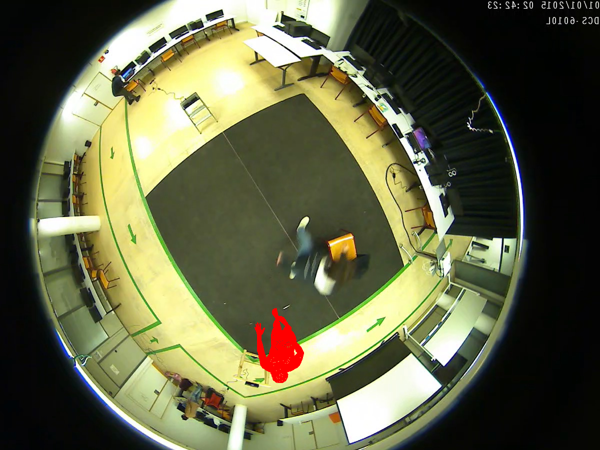

100%|██████████| 2576/2576 [08:22<00:00,  5.13it/s]

[*] Done!


In [17]:
# To render the projected meshes on the images
vertices_2d, mesh = render_on_images(cam1_images_path, transformed_meshes, cam1_calib, output_path)

In [ ]:
# float_formatter = "{:.4f}".format
# np.set_printoptions(formatter={'float_kind':float_formatter})
# print("OpenCV matrices")
# print(f"Kinect{num}_to_world: \n{cam0_to_world}, \n\n\nKinect{num}_world_to_omni: \n{world_to_cam1}")




# # Get the first rotation matrix and first translation vectors
# R_kinect = np.array(kParams["RotationMatrices"])[...,0]
# t_kinect = np.array(kParams["TranslationVectors"])[0].reshape(3, 1)
# print("Matlab matrices for kinect to checkerboard")

# # print("R: \n", R, "\n\n t: \n", t)

# RT01 = np.concatenate((R_kinect, t_kinect.reshape(3, 1)), axis=1)
# RT01 = np.concatenate((RT01, np.array([[0, 0, 0, 1]])), axis=0)

# print("RT01: \n", RT01)

# # Get the second rotation matrix and second translation vectors
# R_omni = np.array(omniParams["RotationMatrices"])[...,0]
# t_omni = np.array(omniParams["TranslationVectors"])[0].reshape(3, 1)
# print("Matlab matrices for omni to checkerboard")

# # print("R: \n", R, "\n\n t: \n", t)

# RT12 = np.concatenate((R_omni, t_omni.reshape(3, 1)), axis=1)
# RT12 = np.concatenate((RT12, np.array([[0, 0, 0, 1]])), axis=0)

# print("RT12: \n", np.linalg.pinv(RT12))

In [ ]:
# # Invert the Kinect transformation to go from Kinect camera frame to the world frame
# R_world_to_kinect = R_kinect.T  # Transpose to invert the rotation
# T_world_to_kinect = -R_world_to_kinect @ t_kinect

# # Create the transformation matrix from Kinect to world
# transform_kinect_to_world = np.eye(4)  # Start with an identity matrix
# transform_kinect_to_world[:3, :3] = R_world_to_kinect
# transform_kinect_to_world[:3, 3] = T_world_to_kinect.squeeze()

# # Create the transformation matrix from world to Omni
# transform_world_to_omni = np.eye(4)  # Start with an identity matrix
# transform_world_to_omni[:3, :3] = R_omni
# transform_world_to_omni[:3, 3] = t_omni.squeeze()

# # Compute the composite transformation matrix
# composite_transform = transform_world_to_omni @ transform_kinect_to_world

In [ ]:
faces = c2c(pred_body.f)
body_mesh_seq = [
    trimesh.Trimesh(
        vertices=c2c(pred_body.v[i]),
        faces=faces,
        process=False,
    )
    for i in range(pred_body.v.size(0))
]

t_body_mesh_seq = []
for body_mesh in tqdm(body_mesh_seq, total=len(body_mesh_seq)):       
    # Apply transform
    print(body_mesh)
    break
# # Save the mesh sequence
# mesh_seq_path = os.path.join("/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/capture1/results_out/final_results/", "mesh_sequence_blender.pkl")
# with open(mesh_seq_path, "wb") as f:
#     pickle.dump(body_mesh_seq, f)

# # save pred_body into a pickle file
# pred_body_path = os.path.join("/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/capture1/results_out/final_results/", "pred_body_for_blender.pkl")
# with open(pred_body_path, "wb") as f:
#     pickle.dump(pred_body, f)



In [ ]:
point_cloud = trimesh.points.PointCloud(body_mesh_seq[0].vertices)
print(point_cloud.vertices)

In [ ]:
# jsonpath = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/k0Params_unaltered.json"
# with open(jsonpath, "r") as f:
#     k0Params = json.load(f)
# # # Get the first translation vector and move the point cloud by a small amount to the left
# # t = np.array(k2Params["TranslationVectors"])[0]
# # # t = t.reshape(1, 3)
# # t[0] += 3000
# # # # t[1] += 0.05
# # # # t[2] -= 0.05
# # # t = t.reshape(1, 3)
# # k2Params["TranslationVectors"][0] = t.tolist()

# #####################
# # Since each element in "RotationMatrices" is a row of a 3x3 matrix,
# # we need to ensure we construct the matrix properly.

# # Get the first rotation matrix (which is already in transposed form due to JSON structure)
# R = np.array(k0Params["RotationMatrices"])

# # Define the rotation matrix for a 90-degree rotation about the z-axis
# R2 = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

# # Rotate the matrix by 90 degrees
# R_rotated = R2 @ R  # This will now be a proper matrix multiplication

# # The result is the new rotated matrix, which we need to convert to a list of lists
# # to be JSON serializable
# k0Params["RotationMatrices"] = R_rotated.tolist()

# # Write the new k2Params to a json file
# with open("/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/k0Params.json", "w") as f:
#     json.dump(k0Params, f)

In [ ]:
# jsonpath = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/k2Params_unaltered.json"
# with open(jsonpath, "r") as f:
#     k2Params = json.load(f)
# # Get the first translation vector and move the point cloud by a small amount to the left
# t = np.array(k2Params["TranslationVectors"])[0]
# # t = t.reshape(1, 3)
# t[0] -= 300
# # # t[1] += 0.05
# # # t[2] -= 0.05
# # t = t.reshape(1, 3)
# k2Params["TranslationVectors"][0] = t.tolist()

# #####################

# # # Since each element in "RotationMatrices" is a row of a 3x3 matrix,
# # # we need to ensure we construct the matrix properly.

# # # Get the first rotation matrix (which is already in transposed form due to JSON structure)
# # R = np.array(k2Params["RotationMatrices"])

# # # Define the rotation matrix for a 90-degree rotation about the z-axis
# # R2 = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

# # # Rotate the matrix by 90 degrees
# # R_rotated = R2 @ R  # This will now be a proper matrix multiplication

# # # The result is the new rotated matrix, which we need to convert to a list of lists
# # # to be JSON serializable
# # k2Params["RotationMatrices"] = R_rotated.tolist()

# ##########################
# # # The first rotation matrix represents the orientation of the checkerboard relative to the camera
# # checkerboard_rotation = np.array(k2Params["RotationMatrices"][0])

# # # Define the rotation matrix for a 90-degree clockwise rotation about the z-axis
# # # This is the transpose (and thus the inverse) of the counterclockwise rotation matrix
# # R2 = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])

# # # Rotate the checkerboard's rotation matrix by the new rotation matrix
# # # This effectively rotates the checkerboard position according to the camera
# # rotated_checkerboard_rotation = R2 @ checkerboard_rotation

# # # Update the first rotation matrix with the new rotated matrix
# # k2Params["RotationMatrices"][0] = rotated_checkerboard_rotation.tolist()

# # Write the new k2Params to a json file
# with open("/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/k2Params.json", "w") as f:
#     json.dump(k2Params, f)


In [ ]:
# # Script to trim files for intrinsic calibration
# path = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/calib/intrinsics/capture2/rgb"
# dst = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/calib/intrinsics/capture2/rgb_trimmed"

# # path = "/home/sid/Projects/OmniScience/dataset/session-recordings/2022-09-23/at-a02/kitchen/calib/omni-self"
# # dst =  "/home/sid/Projects/OmniScience/dataset/session-recordings/2022-09-23/at-a02/kitchen/calib/omni-self_trimmed"


# os.makedirs(dst, exist_ok=True)
# for ix, file in enumerate(os.listdir(path)):
#     # select the 20th image and copy into dst
#     if ix % 15 == 0:
#         shutil.copy(os.path.join(path, file), os.path.join(dst, file))

# # Check number of images in dst
# len(os.listdir(dst))

In [ ]:
# Code to process the framekeeper file
import pandas as pd
file = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/framekeeper_list.txt"

df = pd.read_csv(file, sep=", ", header=None)
df.columns = ["capture0", "capture1", "capture2", "omni"]+
df.to_csv("/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/framekeeper_list_corrected.csv", sep=";", index=False)

In [ ]:
df2 = pd.read_csv("/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/sid/framekeeper_list_corrected.csv", sep=";", header=0)
# select row 2
image = df2.iloc[2]["capture2"]
image = os.path.basename(image.replace("'", "").replace("png", "jpg"))
image

In [ ]:
extrinsic_path = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/calib/extrinsics/k2-extrinsics/omni"
intrinsic_path = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/calib/intrinsics/omni/omni_trimmed"
intrinsic_path_smaller = "/home/sid/Projects/OmniScience/dataset/session-recordings/2024-01-12/at-unis/lab/calib/intrinsics/omni/omni_trimmed_smaller"

In [ ]:
# # Flip all the images in the folders
# for i in [intrinsic_path, extrinsic_path, intrinsic_path_smaller]:
#     dst = i + "_flipped"
#     print(dst)
#     os.makedirs(dst, exist_ok=True)
#     for file in os.listdir(i):
#         img = Image.open(os.path.join(i, file))
#         img = ImageOps.mirror(img)
#         img.save(os.path.join(dst, file))
